In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [3]:
df = pd.read_csv('23-24_closing_prices.csv', index_col=0)
df = df.bfill()
prices = np.array(df.values)

In [4]:
# Expressed as percentage returns
returns = 100 * (prices[1:, :] - prices[:-1, :]) / prices[:-1, :]
mu = returns.mean(axis=0)

In [5]:
r = returns - mu[None, :]
S = (r.T[:, :, None] * r[None, :, :]).sum(axis=1) / (len(returns) - 1)

We solve the optimization problem
$$\min_w \lambda w^T\Sigma w - w^T\mu$$
To write this in a least squares form
$$\|Ax-b\|^2=(Ax-b)^T(Ax-b)=x^TA^TAx-2x^TAb+b^Tb$$

We therefore have
$$A=\sqrt{\lambda} \Sigma^{1/2}, b=A^{-1}\mu/2$$

In [6]:
eig_vals, U = np.linalg.eigh(S)
sqrt_S = U @ np.diag(np.sqrt(eig_vals)) @ U.T
sqrt_S_inv = U @ np.diag(1 / np.sqrt(eig_vals)) @ U.T

In [7]:
l_vals = np.linspace(0.01, 1, 200)
return_vals = 0 * l_vals
volatility_vals = 0 * l_vals

for i in range(len(l_vals)):
    l = l_vals[i]
    
    A = U @ np.diag(np.sqrt(l * eig_vals)) @ U.T
    A_inv = U @ np.diag(1 / np.sqrt(l * eig_vals)) @ U.T
    b = A_inv @ mu / 2
    
    x = cp.Variable(len(mu))
    constraints = [x >= 0, sum(x) == 1]
    objective = cp.Minimize(cp.sum_squares(A @ x - b))

    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    w = x.value
    w[w < 0] = 0
    w /= w.sum()
    
    return_vals[i] = mu @ w
    volatility_vals[i] = np.sqrt((w @ S) @ w)

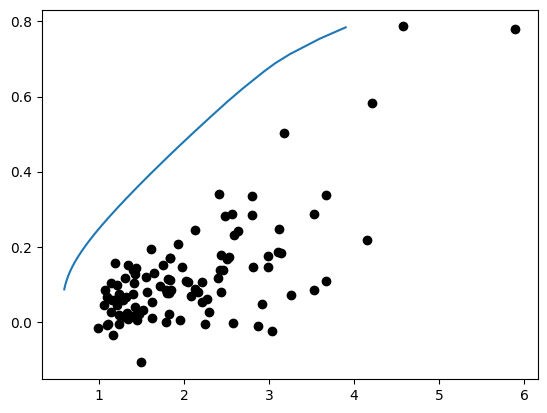

In [8]:
plt.plot(volatility_vals, return_vals)
for i in range(len(mu)):
    plt.scatter(np.sqrt(S[i, i]), mu[i], color='black')

We solve the optimization problem
$$\min_n \lambda n^T\Sigma'n - n^T\mu'$$
To write this in a least squares form
$$\|Ax-b\|^2=(Ax-b)^T(Ax-b)=x^TA^TAx-2x^TAb+b^Tb$$

We therefore have
$$A=\sqrt{\lambda \Sigma'}, b=A^{-1}\mu'/2$$

In [196]:
B = 1e6
P = prices[-1]
rel_P = P / B

In [197]:
mu_prime = rel_P * mu
S_prime = (rel_P[:, None] * rel_P[None, :]) * S

eig_vals, eig_vec = np.linalg.eigh(S_prime)

In [198]:
l = 0.5

A = eig_vec @ np.diag(np.sqrt(l * eig_vals)) @ eig_vec.T
A_inv = eig_vec @ np.diag(1 / np.sqrt(l * eig_vals)) @ eig_vec.T
b = A_inv @ mu_prime / 2

In [199]:
x = cp.Variable(len(P), integer=True)
constraints = [x >= 0, rel_P @ x == 1]
objective = cp.Minimize(cp.sum_squares(A @ x - b))
problem = cp.Problem(objective, constraints)

problem.solve()
problem.status

'optimal'

In [200]:
np.arange(len(P))[x.value > 0]

array([ 0,  6, 12, 16, 17, 19, 21, 27, 30, 38, 39, 40, 41, 45, 47, 53, 54,
       56, 64, 68, 70, 71, 75, 79, 84, 90, 95, 96, 99])

In [201]:
x.value @ rel_P

np.float64(0.9999996546192169)

In [202]:
mu_prime @ x.value, x.value @ S_prime @ x.value

(np.float64(0.1170299445971808), np.float64(0.39727684728641877))

In [220]:
A_torch = torch.tensor(A, dtype=torch.float64)
b_torch = torch.tensor(b, dtype=torch.float64)
rel_P_torch = torch.tensor(rel_P, dtype=torch.float64)

In [351]:
potential = lambda x: torch.linalg.norm(x @ A_torch - b_torch, axis=-1)
isvalid = lambda x: (x >= 0).all(axis=-1) * (x @ rel_P_torch <= 1) * (x @ rel_P_torch >= 0.9)

def regularized_potential(x):
    with torch.no_grad():
        mask = isvalid(torch.round(x)).to(torch.float64)
    
    return mask * potential(x) \
            + 1000 * (1 - mask) * torch.max(torch.tensor(0), x @ rel_P_torch - 1) ** 2 \
            + 100 * (1 - mask) * (torch.max(torch.tensor(0), -particles) ** 2).sum(axis=-1)

In [352]:
dim = len(P)

In [353]:
num_particles = 10
particles = np.random.normal(0, 0.1, (num_particles, dim))
particles = torch.tensor(particles, dtype=torch.float64, requires_grad=True)

counter = 2

C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [354]:
h = 0.01
beta = 1
C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [428]:
best_particle = torch.zeros(dim, dtype=torch.float64)
best_val = np.inf

num_iters = 5000
# counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_particles = rounded_particles[isvalid(rounded_particles) > 0]
        
        if len(rounded_particles) > 0:
            rounded_vals = potential(rounded_particles)
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
        history[i] = vals.min()
    
        # C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
            best_val = rounded_history[i]
    
    counter += 1
    particles.grad.zero_()

In [429]:
particles @ rel_P_torch

tensor([0.9899, 0.9537, 0.9671, 1.0068, 1.0081, 0.9789, 0.7476, 0.9303, 0.8730,
        0.9229], dtype=torch.float64, grad_fn=<MvBackward0>)

In [430]:
potential(torch.tensor(x.value, dtype=torch.float64))

tensor(0.4123, dtype=torch.float64)

In [431]:
best_val

tensor(0.6272, dtype=torch.float64)

In [432]:
best_particle @ rel_P_torch

tensor(0.9002, dtype=torch.float64)

In [422]:
history

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [392]:
potential(best_particle)

tensor(0.6260, dtype=torch.float64)

In [279]:
potential(torch.tensor(x.value, dtype=torch.float64))

tensor(0.4123, dtype=torch.float64)

In [280]:
x.value

array([ 209.,   -0.,   -0.,   -0.,    0.,   -0.,  351.,   -0.,   -0.,
         -0.,   -0.,   -0.,   28.,    0.,   -0.,   -0.,   27.,  574.,
         -0.,    6.,    0., 1197.,   -0.,   -0.,    0.,   -0.,    0.,
         52.,    0.,   -0.,  214.,   -0.,    0.,   -0.,    0.,    0.,
         -0.,    0.,   42.,   47.,  425.,   26.,    0.,    0.,   -0.,
        289.,    0.,   39.,   -0.,   -0.,    0.,   -0.,   -0., 2673.,
        467.,   -0.,   54.,   -0.,   -0.,    0.,   -0.,   -0.,    0.,
         -0.,   45.,    0.,   -0.,    0.,   13.,    0.,   18.,  261.,
         -0.,   -0.,   -0.,   68.,    0.,    0.,    0.,   16.,    0.,
          0.,   -0.,   -0.,    4.,   -0.,    0.,   -0.,   -0.,   -0.,
        682.,   -0.,   -0.,    0.,   -0.,  340.,   12.,    0.,   -0.,
        311.,   -0.])

In [281]:
best_particle

tensor([43., 20.,  1., 48., 65., 34., 23., 20., 11., 16., 20., 36., 21., 39.,
        13., 12.,  8.,  3., 55., 51., 21.,  8., 25., 28., 17., 21., 29., 53.,
        38.,  1., 29.,  4., 35.,  1., 48., 41., 35.,  6.,  6., 34., 16., 27.,
        33.,  6., 82., 31., 44., 22., 61., 13., 39., 41., 28., 42.,  2.,  9.,
        15., 33., 15., 10., 34., 44., 44., 52.,  1.,  9., 20., 19., 36., 15.,
        15., 22., 24., 12., 26., 27., 20.,  3.,  5., 38., 51., 37., 23., 33.,
        22., 42., 39., 44., 17.,  5., 20., 13., 25., 35., 24., 22., 35., 31.,
        15.,  4., 12.], dtype=torch.float64)

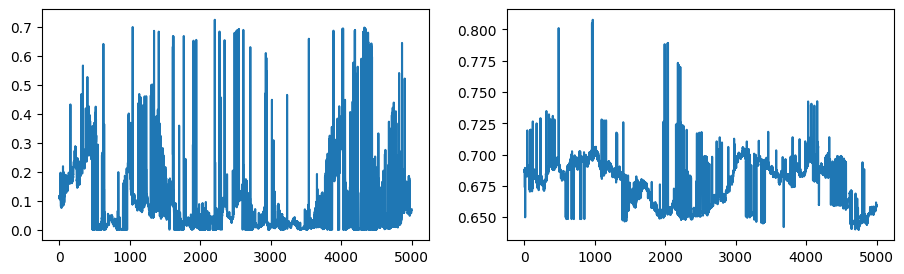

In [282]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [162]:
rounded_history.min()

tensor(-0.8305, dtype=torch.float64)

In [163]:
history.min()

tensor(0., dtype=torch.float64)

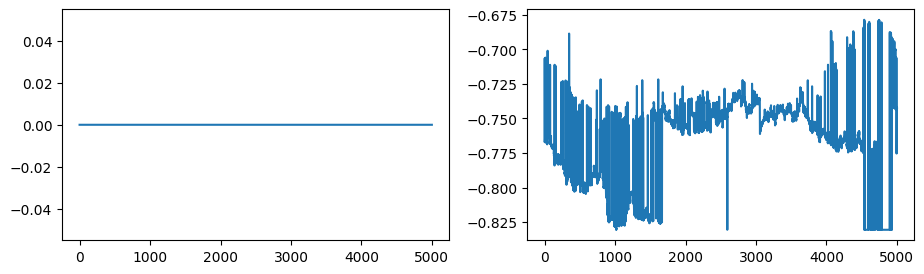

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [165]:
rel_P_torch @ best_particle

tensor(0.9994, dtype=torch.float64)

In [166]:
potential(best_particle)

tensor(-0.8305, dtype=torch.float64)

In [167]:
best_particle

tensor([  1.,  36.,  31.,   4.,  26.,  15.,  25.,  16.,  42.,  23.,   3.,  45.,
         12.,  16.,  14.,  24.,  18.,  26.,   3., 114.,  12.,   3.,   2.,   6.,
          7.,  10.,  24.,  19.,  24.,   0.,   9.,  27.,  12.,   0.,  14.,  15.,
         26.,   2.,   4.,   6.,  29.,   6.,  38.,  24.,  25.,   4.,  23.,  17.,
          1.,  19.,  23.,  16.,  23.,  11.,  15.,  15.,  11.,  50.,   7.,   6.,
         17.,  23.,  13.,  42.,  15.,  40.,   9.,  20.,  38.,  15.,  10.,   1.,
         17.,   8.,   9.,  20.,  44.,   2.,  54.,  53.,   7.,  20.,   5.,  34.,
         11.,   1.,  16.,   3.,  11.,   2.,  23.,   0.,   1.,   2.,   5.,  11.,
         24.,  19.,   6.,  40.,  12.], dtype=torch.float64)

In [ ]:
h = 0.01

best_val = np.inf
best_particle = None

num_iters = 5000
counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_vals = regularized_potential(rounded_particles)
        history[i] = vals.min()
        rounded_history[i] = rounded_vals.min()
    
        # C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
    
    counter += 1
    particles.grad.zero_()

In [391]:
# x.value[x.value > 0]

In [403]:
A_torch = torch.tensor(A, dtype=torch.float64)
b_torch = torch.tensor(b, dtype=torch.float64)
rel_P_torch = torch.tensor(rel_P, dtype=torch.float64)

In [404]:
potential = lambda x: torch.linalg.norm(A_torch @ x - b_torch)
is_valid = lambda x: ((rel_P_torch @ x) <= 1) and (x >= 0).all()

In [405]:
potential(torch.tensor(x.value, dtype=torch.float64)).detach().numpy()

array(0.72720933)

In [406]:
num_iters = 10_000
dim = len(P)

v = np.ones(2 * dim) * 0.01

# particle = torch.tensor(np.ones(dim), dtype=torch.float64, requires_grad=True)
particle = torch.tensor(x.value, dtype=torch.float64, requires_grad=True)
D_temp = torch.ones(dim, dtype=torch.float64)
C = torch.diag(D_temp)
sqrt_C = torch.diag(D_temp)
counter = 1
alpha = 0.1
h = 0.1
w = np.ones(2 * dim)

In [407]:
C = torch.eye(len(mu), dtype=torch.float64)

In [425]:
# D_temp = torch.ones(dim, dtype=torch.float64)
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    a = 0.1 * np.cos(np.pi * i / 1000) ** 2 + 0.00001
    d = -C @ particle.grad + np.sqrt(2) * sqrt_C @ torch.randn_like(particle) * a
    k = torch.argmax(abs(d))
        
    with torch.no_grad():
        particle[k] += 1 if d[k] > 0 else -1
        D_temp = (1 - alpha) * D_temp + alpha * particle.grad ** 2

        C = torch.diag(1 / torch.sqrt(D_temp))
        # sqrt_C = torch.sqrt(C)
        # v = torch.concatenate([D_temp, D_temp]).detach().numpy()

        if not is_valid(particle):
            num_invalid_moves += 1
            particle[k] += -1 if d[k] > 0 else 1
        history[i] = particle
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: 0.23946908820294005
Iteration 1000: 0.2394249168695808
Iteration 2000: 0.23942315991877003
Iteration 3000: 0.23942183416902832
Iteration 4000: 0.23942069958310322
Iteration 5000: 0.2394204664993118
Iteration 6000: 0.2394204664993118
Iteration 7000: 0.23942046597347347
Iteration 8000: 0.23942046597347347
Iteration 9000: 0.23942046597347347
Iteration 9999: 0.23942046597347347


In [426]:
potential(torch.tensor(x.value, dtype=torch.float64)).detach().numpy()

array(0.72720933)

In [427]:
potential(best_particle).detach().numpy()

array(0.23942047)

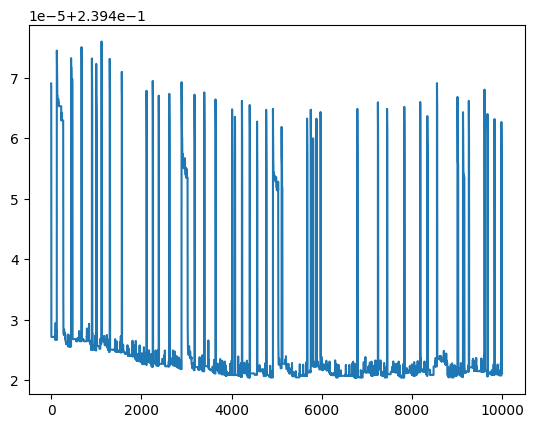

In [428]:
plt.plot(history_val)

In [435]:
w = best_particle.detach().numpy()
w *= 2
rel_P @ w

np.float64(0.862493566040039)

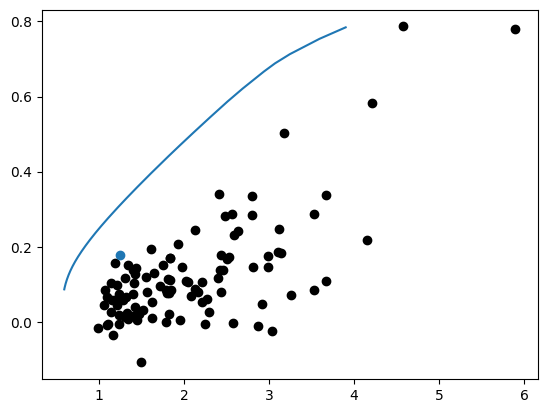

In [176]:
# w = x.value

plt.plot(volatility_vals, return_vals)
for i in range(len(mu)):
    plt.scatter(np.sqrt(S[i, i]), mu[i], color='black')

w = best_particle.detach().numpy()
# w *= 2
w[w < 0] = 0
plt.scatter(np.sqrt(w @ S_prime @ w), mu_prime @ w)

In [430]:
w = best_particle.detach().numpy()
temp_w = w * rel_P
temp_w.sum()

np.float64(0.21562339151000975)

In [385]:
temp_w @ S @ temp_w, temp_w @ mu

(np.float64(0.0620599518232224), np.float64(0.06212360421466005))

In [432]:
w @ S_prime @ w, w @ mu_prime

(np.float64(0.24823980729288964), np.float64(0.1242472084293201))

In [433]:
rel_P @ w

np.float64(0.4312467830200195)

In [194]:
# D_temp = torch.ones(dim, dtype=torch.float64)
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    d = -particle.grad
    k = np.random.choice(range(dim))
        
    with torch.no_grad():
        particle[k] += 1 if d[k] > 0 else -1
        # sqrt_C = torch.sqrt(C)
        # v = torch.concatenate([D_temp, D_temp]).detach().numpy()

        if not is_valid(particle):
            num_invalid_moves += 1
            particle[k] += -1 if d[k] > 0 else 1
        history[i] = particle
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: 0.1694043399824616
Iteration 1000: 0.16932008517725086
Iteration 2000: 0.16932008517725086
Iteration 3000: 0.16932008517725086
Iteration 4000: 0.16932008517725086
Iteration 5000: 0.16932008517725086
Iteration 6000: 0.16932008517725086
Iteration 7000: 0.16932008517725086
Iteration 8000: 0.16932008517725086
Iteration 9000: 0.16932008517725086
Iteration 9999: 0.16932008517725086


In [195]:
potential(torch.tensor(x.value, dtype=torch.float64)).detach().numpy()

array(0.16931774)

In [196]:
potential(best_particle).detach().numpy()

array(0.16932009)

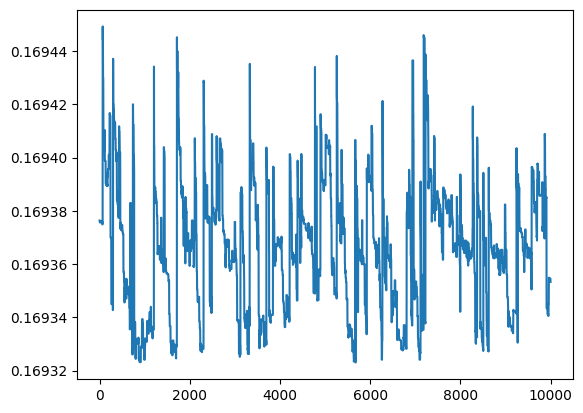

In [190]:
plt.plot(history_val)

In [408]:
w.shape

(202,)

In [409]:
num_invalid_moves

2994

In [410]:
val = potential(particle)
val.backward()
print(C @ particle.grad)
particle.grad.zero_();

tensor([ 1.3669,  1.0168,  1.0182,  1.0194,  1.0374,  1.0205,  1.0254,  1.0189,
         1.0204,  1.0154,  1.0450,  1.0178,  1.8101,  1.0213,  1.0133,  1.3034,
         1.2341,  1.0131,  1.0045,  0.9070,  1.1134, -0.3181,  1.0245,  1.0139,
         1.1436,  1.0111,  1.0125, -0.0707,  1.0522,  1.0346,  1.0276,  1.0110,
         1.0137,  1.0639,  1.0314,  1.0604,  1.0217,  1.0089,  1.0196,  1.0033,
         1.1565,  1.0482,  1.0557,  1.0235,  1.0111, -0.9002,  1.0522,  1.0528,
         1.0143,  1.0124,  1.0107,  1.0347,  1.0383,  1.0090,  1.0004,  1.0191,
         1.0590,  1.0236,  1.0153,  1.0659,  1.0120,  1.0168,  1.0082,  1.0517,
        -0.7574,  1.0153,  1.0264,  1.0341,  1.1995,  1.0196,  1.1372,  1.2907,
         1.0185,  1.0182,  1.0141, -0.9232,  1.0680,  1.0277,  1.0539,  1.0166,
         1.0055, -0.4743,  1.0104,  1.0163,  1.0140,  1.0214,  1.0228,  1.0088,
         1.0184,  1.0322, -0.8307,  1.0488,  1.0266,  1.0368,  1.0151, -0.8335,
         1.0932,  1.0103,  1.0371,  1.04

In [411]:
(w / w.sum()).max()

np.float64(0.010036849442675475)

In [412]:
potential(best_particle.detach().clone())

tensor(0.1693, dtype=torch.float64)

In [413]:
is_valid(torch.tensor(x.value, dtype=torch.float64)).detach().numpy()

array(True)

In [414]:
is_valid(best_particle)

tensor(True)

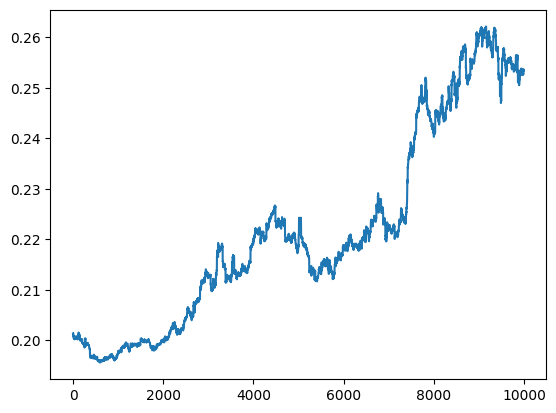

In [460]:
plt.plot(history_val)

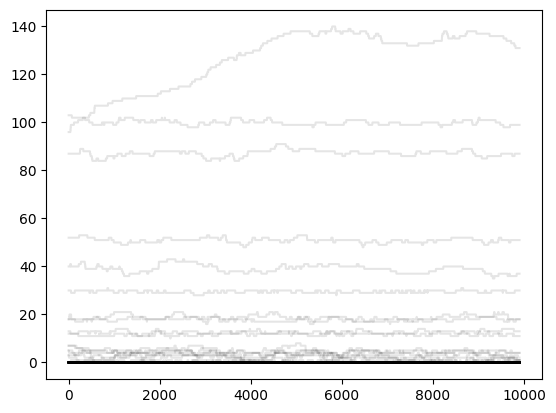

In [402]:
for i in range(dim):
    plt.plot(history[100:, i], color='black', alpha=0.1)

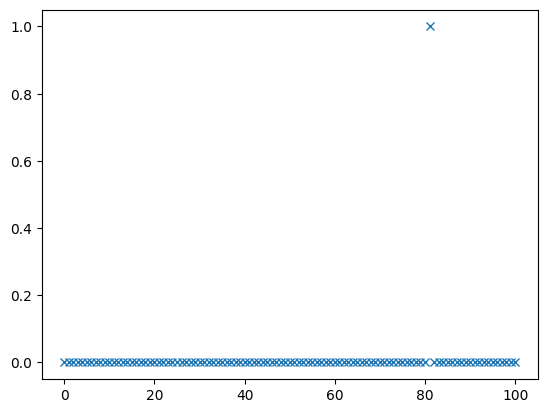

In [467]:
# plt.plot(best_particle, 'o')
plt.plot(abs(x.value - best_particle.detach().numpy()), 'x')

In [403]:
temp_particle = best_particle.detach().clone().requires_grad_(True)
val = potential(temp_particle)
val.backward()
print(C @ temp_particle.grad)
temp_particle.grad.zero_();

tensor([-0.8387,  0.9958,  0.9942,  1.0042,  0.9982,  1.0007,  1.0307,  0.9999,
         0.9949,  1.0009,  0.9689,  0.9964,  0.6523,  1.0067,  1.0010,  0.2677,
        -1.0458,  1.0121,  1.0022,  1.0049,  1.1477,  5.1209,  0.9973,  1.0028,
        -1.0713,  1.0080,  0.9987, -1.7192,  0.9996,  0.9998,  1.0088,  1.0001,
         1.0024,  0.9974,  0.9940,  0.9897,  0.9976,  0.9971,  1.0005,  1.0191,
         2.0410,  0.9960,  1.0067,  1.0038,  1.0041,  1.2112,  0.9612,  0.9599,
         1.0017,  0.9978,  1.0011,  0.9938,  0.9824,  1.0220,  1.0120,  1.0019,
         1.0014,  0.9994,  1.0005,  1.0080,  1.0022,  0.9955,  0.9962,  0.9738,
        -0.2991,  0.9957,  1.0005,  0.9816,  1.0447,  1.0051,  0.7109, -0.5433,
         1.0038,  0.9971,  1.0036, -1.1295,  0.9882,  0.9983,  1.0242,  1.0034,
         1.0000,  0.2861,  0.9996,  1.0043,  0.9970,  0.9953,  1.0033,  1.0054,
         0.9979,  1.0012, -0.1523,  1.0169,  0.9910,  0.9944,  1.0036, -2.0206,
         1.0127,  1.0021,  1.0000,  1.04

In [404]:
temp_particle = torch.tensor(x.value, dtype=torch.float64, requires_grad=True)
val = potential(temp_particle)
val.backward()
print(C @ temp_particle.grad)
temp_particle.grad.zero_();

tensor([ 0.3031,  0.9993,  0.9991,  1.0057,  1.0088,  1.0039,  1.0518,  1.0013,
         0.9974,  1.0034,  0.9834,  0.9991,  0.8830,  1.0065,  1.0006, -0.1295,
        -0.7831,  1.0106,  1.0019,  1.0246,  1.0864,  1.0317,  1.0011,  1.0039,
        -0.6919,  1.0086,  0.9989,  1.2339,  1.0132,  1.0056,  1.0121,  1.0024,
         1.0030,  1.0140,  0.9983,  1.0104,  1.0010,  1.0010,  1.0055,  1.0185,
        -0.1156,  1.0044,  1.0315,  1.0054,  1.0042,  1.0388,  0.9815,  0.9806,
         1.0053,  1.0012,  1.0021,  0.9995,  0.9968,  1.0264,  1.0097,  1.0022,
         1.0047,  1.0011,  1.0019,  1.0122,  1.0027,  0.9990,  1.0009,  0.9986,
        -0.0264,  1.0034,  1.0043,  0.9922,  1.2962,  1.0032,  1.0495, -0.1473,
         1.0044,  1.0017,  1.0035, -0.5369,  1.0145,  1.0073,  1.0161,  0.9990,
         1.0051,  0.6430,  1.0009,  1.0062,  1.0000,  1.0006,  1.0116,  1.0063,
         1.0004,  1.0051,  0.4751,  1.0294,  0.9985,  1.0035,  1.0051,  1.8457,
         1.0206,  1.0024,  1.0046,  1.07